In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os

#print (os.listdir('/content/gdrive/My Drive/MILIZE/'))
print (os.listdir('/content/gdrive/My Drive/MILIZE/Semantic/carvana/'))

['u_net_vgg16_carvana.ipynb', 'train', 'train_masks', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']


Library

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from tqdm import tqdm

from PIL import Image

from sklearn.model_selection import train_test_split

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Dropout, Conv2D, Conv2DTranspose
from keras.layers import concatenate

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


Get data

In [0]:
path_img = '/content/gdrive/My Drive/MILIZE/Semantic/carvana/train/'
path_mask = '/content/gdrive/My Drive/MILIZE/Semantic/carvana/train_masks/'

In [5]:
files = os.listdir(path_img)
ids = [f[:-4] for f in files]

print (len(ids))
print (ids[:3])

5088
['cf65b1c5e147_07', 'cf65b1c5e147_08', 'cf65b1c5e147_14']


shape:  (256, 256, 3)


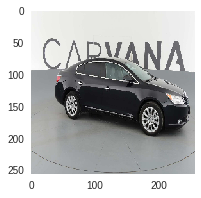


mode of mask_pil:  P
shape:  (256, 256)


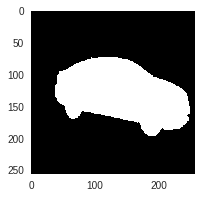

In [6]:
file_name = ids[np.random.randint(100)]

size = 256

img_pil = Image.open(path_img+file_name+'.jpg').resize((size, size))
img_np = np.array(img_pil)

print ('shape: ', img_np.shape)

plt.figure(figsize=(5, 3))
plt.imshow(img_np)
plt.grid(False)
plt.show()

print ()

mask_pil = Image.open(path_mask+file_name+'_mask.gif').resize((size, size))
print ('mode of mask_pil: ', mask_pil.mode)

mask_np = np.array(mask_pil)
print ('shape: ', mask_np.shape)
#print (mask_np[150, :])

plt.figure(figsize=(5, 3))
plt.imshow(mask_np, cmap='gray')
plt.grid(False)
plt.show()

In [7]:
%%time

selected = np.random.choice(len(ids), 200, replace=False)

x = []
y = []
size = 256

for i in tqdm(selected):
  file_name = ids[i]
  
  img_pil = Image.open(path_img+file_name+'.jpg').resize((size, size))
  img_np = np.array(img_pil)
  x.append(img_np)
  
  mask_pil = Image.open(path_mask+file_name+'_mask.gif').resize((size, size))
  mask_np = np.array(mask_pil)
  mask_np = np.expand_dims(mask_np, axis=-1)
  y.append(mask_np)

100%|██████████| 200/200 [01:50<00:00,  1.76it/s]

CPU times: user 8.85 s, sys: 259 ms, total: 9.1 s
Wall time: 1min 50s


Create training data

In [8]:
x = np.array(x)
y = np.array(y)

print ('shape of x: ', x.shape)
print ('shape of y: ', y.shape)

#print (y[0, 250, 100:150, 0])

shape of x:  (200, 256, 256, 3)
shape of y:  (200, 256, 256, 1)


In [9]:
x_data = x / 255.0
y_data = y

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, 
                                                     test_size=0.2, random_state=100)

print ('shape of x_train: ', x_train.shape)
print ('shape of y_train: ', y_train.shape)
print ('shape of x_valid: ', x_valid.shape)
print ('shape of y_valid: ', y_valid.shape)

shape of x_train:  (160, 256, 256, 3)
shape of y_train:  (160, 256, 256, 1)
shape of x_valid:  (40, 256, 256, 3)
shape of y_valid:  (40, 256, 256, 1)


In [0]:
del df_train, x, y

NameError: ignored

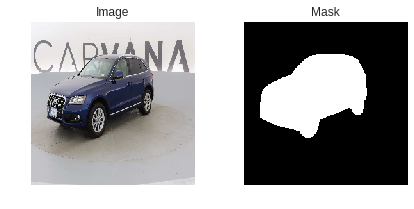

% of 1:  22.24273681640625


In [10]:
idx = np.random.randint(len(x_train))

fig = plt.figure(figsize = (7, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(x_train[idx])
ax1.set_title('Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(np.squeeze(y_train[idx]), cmap='gray')
ax2.set_title('Mask')
ax2.set_axis_off()

plt.show()

print ('% of 1: ', np.sum(y_train[idx]/size**2 * 100))

In [0]:
#x_train[20, 125, :, 0]
#y_train[20, 125, :, 0]

Model

In [11]:
img_width = size
img_height = size

input_tensor = Input(shape=(img_width, img_height, 3))
    
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

#model_path = '/content/gdrive/My Drive/MILIZE/Semantic/carvana/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg_model = VGG16(weights=model_path, include_top=False, input_tensor=input_tensor)


58892288/58889256 [==============================] - 1s 0us/step


In [0]:
#vgg_model.summary()

In [0]:
vgg_top = vgg_model.get_layer('block5_conv2').output

block1_conv2 = vgg_model.get_layer('block1_conv2').output
block2_conv2 = vgg_model.get_layer('block2_conv2').output
block3_conv3 = vgg_model.get_layer('block3_conv3').output
block4_conv3 = vgg_model.get_layer('block4_conv3').output

In [0]:
n_classes = 1
start_neurons = 64

# 8 -> 16
deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding='same')(vgg_top)
uconv4 = concatenate([deconv4, block4_conv3])
uconv4 = Dropout(0.5)(uconv4)
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(uconv4)
#uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(uconv4)

# 16 -> 32
deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
uconv3 = concatenate([deconv3, block3_conv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
#uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

# 32 -> 64
deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, block2_conv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
#uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

# 64 -> 128
deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
uconv1 = concatenate([deconv1, block1_conv2])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
#uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

out = Conv2D(n_classes, (1,1), padding="same", activation="sigmoid")(uconv1)

model = Model(inputs=input_tensor, outputs=out)

#for layer in model.layers[:17]:
#    layer.trainable = False
    
for layer in vgg_model.layers:
    layer.trainable = False    

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [0]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
early_stopping = EarlyStopping(monitor='val_acc', patience=2, mode='max', 
                              verbose=1)

In [18]:
batch_size = 32
epochs = 3

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(x_valid, y_valid), callbacks=[early_stopping], 
                    verbose=1)

Train on 160 samples, validate on 40 samples
Epoch 1/3
160/160 [==============================] - 35s 216ms/step - loss: 1.1528 - acc: 0.7170 - val_loss: 0.4800 - val_acc: 0.8137
Epoch 2/3
160/160 [==============================] - 13s 82ms/step - loss: 0.5268 - acc: 0.8153 - val_loss: 0.1866 - val_acc: 0.9252
Epoch 3/3
160/160 [==============================] - 13s 83ms/step - loss: 0.2108 - acc: 0.9242 - val_loss: 0.0785 - val_acc: 0.9750


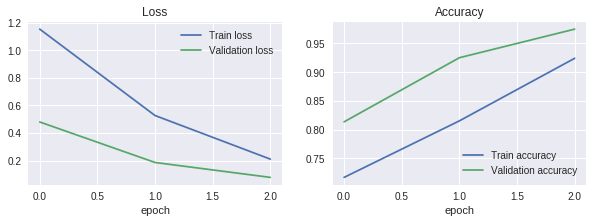

In [19]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(10, 3))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.set_title('Loss')
ax_loss.set_xlabel('epoch')
ax_loss.legend(loc='best')

ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.set_title('Accuracy')
ax_acc.set_xlabel('epoch')
ax_acc.legend(loc='best')
plt.show()

In [25]:
idx = np.random.randint(len(x_valid))

y_valid_prob = model.predict(x_valid[idx:idx+1])
y_valid_pred = (y_valid_prob > 0.5).astype(np.int)

print (y_valid_prob.shape)
#print (y_valid_pred[idx:idx+1, 100, :])
print (np.max(y_valid_pred))
print (np.min(y_valid_pred))

(1, 256, 256, 1)
1
0


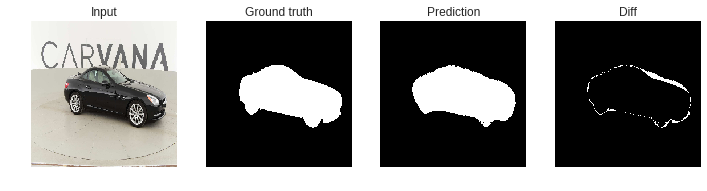

In [26]:
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(x_valid[idx])
ax1.set_title('Input')
ax1.set_axis_off()

ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(np.squeeze(y_valid[idx]), cmap='gray')
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(np.squeeze(y_valid_pred), cmap='gray')
ax3.set_title('Prediction')
ax3.set_axis_off()

ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(np.abs(np.squeeze(y_valid[idx])-np.squeeze(y_valid_pred)), cmap='gray')
ax4.set_title('Diff')
ax4.set_axis_off()

plt.show()

In [0]:
#np.sum((y_train[3]==1).astype(int)) / size**2

#y_valid[idx]
np.min(y_valid_pred)

1

from kaggle kernel

In [0]:
#path_img = '/content/gdrive/My Drive/MILIZE/Semantic/carvana/train/'
#path_mask = '/content/gdrive/My Drive/MILIZE/Semantic/carvana/train_masks/'

INPUT_PATH = '/content/gdrive/My Drive/MILIZE/Semantic/carvana/'
DATA_PATH = INPUT_PATH
TRAIN_DATA = os.path.join(DATA_PATH, "train")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train_masks")

In [0]:
train_files = glob(os.path.join(TRAIN_DATA, "*.jpg"))
train_ids = [s[len(TRAIN_DATA)+1:-4] for s in train_files]

#train_files = os.listdir(TRAIN_DATA)
#train_ids = [f[:-4] for f in files]

In [0]:
train_ids[:3]

['cf65b1c5e147_07', 'cf65b1c5e147_08', 'cf65b1c5e147_14']

In [0]:
%%time

from tqdm import tqdm

selected = np.random.choice(len(train_ids), 200, replace=False)

x = []
y = []
size = 256

for i in tqdm(selected):
    file_name = train_ids[i]

    img_pil = Image.open(TRAIN_DATA+'/'+file_name+'.jpg').resize((size, size))
    img_np = np.array(img_pil)
    x.append(img_np)

    mask_pil = Image.open(TRAIN_MASKS_DATA+'/'+file_name+'_mask.gif').resize((size, size))
    mask_np = np.array(mask_pil)
    mask_np = np.expand_dims(mask_np, axis=-1)
    y.append(mask_np)

100%|██████████| 200/200 [01:49<00:00,  1.76it/s]

CPU times: user 8.86 s, sys: 209 ms, total: 9.06 s
Wall time: 1min 49s


In [0]:
from sklearn.model_selection import train_test_split

x_data = np.array(x) / 255.0
y_data = np.array(y)

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, 
                                                      test_size=0.2, random_state=100)

print ('shape of x_train: ', x_train.shape)
print ('shape of y_train: ', y_train.shape)
print ('shape of x_valid: ', x_valid.shape)
print ('shape of y_valid: ', y_valid.shape)

shape of x_train:  (160, 256, 256, 3)
shape of y_train:  (160, 256, 256, 1)
shape of x_valid:  (40, 256, 256, 3)
shape of y_valid:  (40, 256, 256, 1)


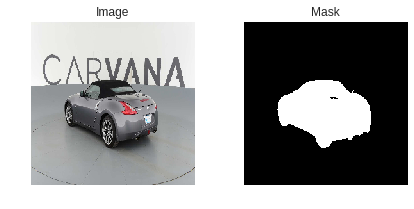

In [0]:
idx = np.random.randint(len(x_train))

fig = plt.figure(figsize = (7, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(x_train[idx])
ax1.set_title('Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(np.squeeze(y_train[idx]), cmap='gray')
ax2.set_title('Mask')
ax2.set_axis_off()

plt.show()

In [0]:
img_width = size
img_height = size

input_tensor = Input(shape=(img_width, img_height, 3))

#vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

model_path = '/content/gdrive/My Drive/MILIZE/Semantic/carvana/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg_model = VGG16(weights=model_path, include_top=False, input_tensor=input_tensor)


In [0]:
#vgg_model.summary()

In [0]:
vgg_top = vgg_model.get_layer('block5_conv2').output

block1_conv2 = vgg_model.get_layer('block1_conv2').output
block2_conv2 = vgg_model.get_layer('block2_conv2').output
block3_conv3 = vgg_model.get_layer('block3_conv3').output
block4_conv3 = vgg_model.get_layer('block4_conv3').output

In [0]:
start_neurons = 64

# 8 -> 16
deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding='same')(vgg_top)
uconv4 = concatenate([deconv4, block4_conv3])
uconv4 = Dropout(0.5)(uconv4)
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(uconv4)
#uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(uconv4)

# 16 -> 32
deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
uconv3 = concatenate([deconv3, block3_conv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
#uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

# 32 -> 64
deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, block2_conv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
#uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

# 64 -> 128
deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
uconv1 = concatenate([deconv1, block1_conv2])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
#uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

out = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

model = Model(inputs=input_tensor, outputs=out)

#for layer in model.layers[:17]:
#    layer.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False 


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
early_stopping = EarlyStopping(monitor='val_acc', patience=2, mode='max', 
                              verbose=1)

In [0]:
batch_size = 32
epochs = 5

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(x_valid, y_valid), callbacks=[early_stopping], 
                    verbose=1)

Train on 160 samples, validate on 40 samples
Epoch 1/5
160/160 [==============================] - 14s 85ms/step - loss: 0.1348 - acc: 0.9618 - val_loss: 0.0785 - val_acc: 0.9733
Epoch 2/5
160/160 [==============================] - 13s 84ms/step - loss: 0.0866 - acc: 0.9728 - val_loss: 0.0752 - val_acc: 0.9700
Epoch 3/5
160/160 [==============================] - 14s 85ms/step - loss: 0.0696 - acc: 0.9786 - val_loss: 0.0526 - val_acc: 0.9778
Epoch 4/5
160/160 [==============================] - 14s 85ms/step - loss: 0.0587 - acc: 0.9791 - val_loss: 0.0534 - val_acc: 0.9760
Epoch 5/5
160/160 [==============================] - 14s 85ms/step - loss: 0.0525 - acc: 0.9816 - val_loss: 0.0436 - val_acc: 0.9810


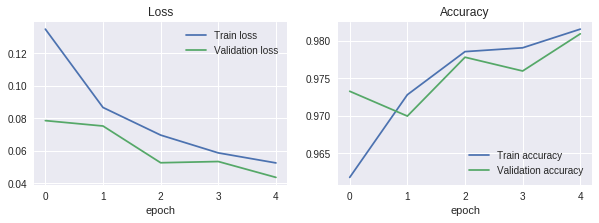

In [0]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(10,3))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.set_title('Loss')
ax_loss.set_xlabel('epoch')
ax_loss.legend(loc='best')

ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.set_title('Accuracy')
ax_acc.set_xlabel('epoch')
ax_acc.legend(loc='best')
plt.show()

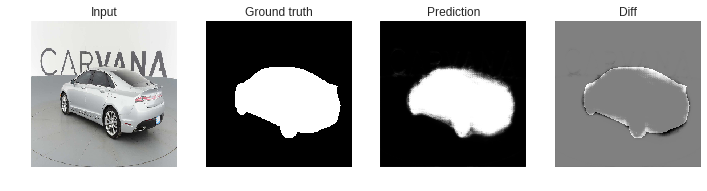

In [0]:
idx = np.random.randint(len(x_valid))
y_valid_pred = model.predict(x_valid[idx:idx+1])

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(x_valid[idx])
ax1.set_title('Input')
ax1.set_axis_off()

ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(np.squeeze(y_valid[idx]), cmap='gray')
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(np.squeeze(y_valid_pred), cmap='gray')
ax3.set_title('Prediction')
ax3.set_axis_off()

ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(np.squeeze(y_valid[idx])-np.squeeze(y_valid_pred), cmap='gray')
ax4.set_title('Diff')
ax4.set_axis_off()

plt.show()